# Anomaly detection
Here we fit a ML model on a clean train dataset and detect anomaly from test set. Since we do not have a ground truth for test set, I used ensemble meta approach to produce the optimal predictive model.  If we assume there is no label the first idea can be clustering and using the distribution of data 
: Gaussian Mixture model. By fitting GMM on the clean data, we can find an acceptable threshold based on the likelihood of each data point belonging to each cluster. Then each data point with less likelihood could be considered as anomaly.<br>
 Another approach could be regression. Energy depends on enthalpy, and there is a relationship between them,hence we can fit the regression model on the training data and define a threshold based on maximum error of the model on train set. In other words, if the error of each data point in test set exceeds the maximum error of model, then it can be considered as anomaly. In this part I used Random Forest regression and K neigrest neighbor. Other ideas like deep models could be used if we had more data in hand.<br>
In the end, we label those points, where all models agree, as anomalies.



In [17]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# main = pd.read_csv('data.csv')


In [18]:
new_train = train.to_numpy()
X_train = new_train[:,2] #enthalpy as x
Y_train = new_train[:,1] # energy as target
new_test = test.to_numpy()
X_test = new_test[:,2] #enthalpy as x
Y_test = new_test[:,1] # energy as target

In [19]:
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



**Model1: Random Forest**

The train data is divided to the validation and train set to evaluate the model. 


In [22]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV

min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train.reshape(-1,1))
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train, test_size=0.1)
#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4 ,5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf
}


random_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=random_grid, cv=5, n_iter=100,n_jobs=-1)

random_rf.fit(x_train.reshape(-1,1), y_train.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 450, 800, 1150,
                                                         1500]})

train error :  74.15116499457744
validation error :  84.77771194622109


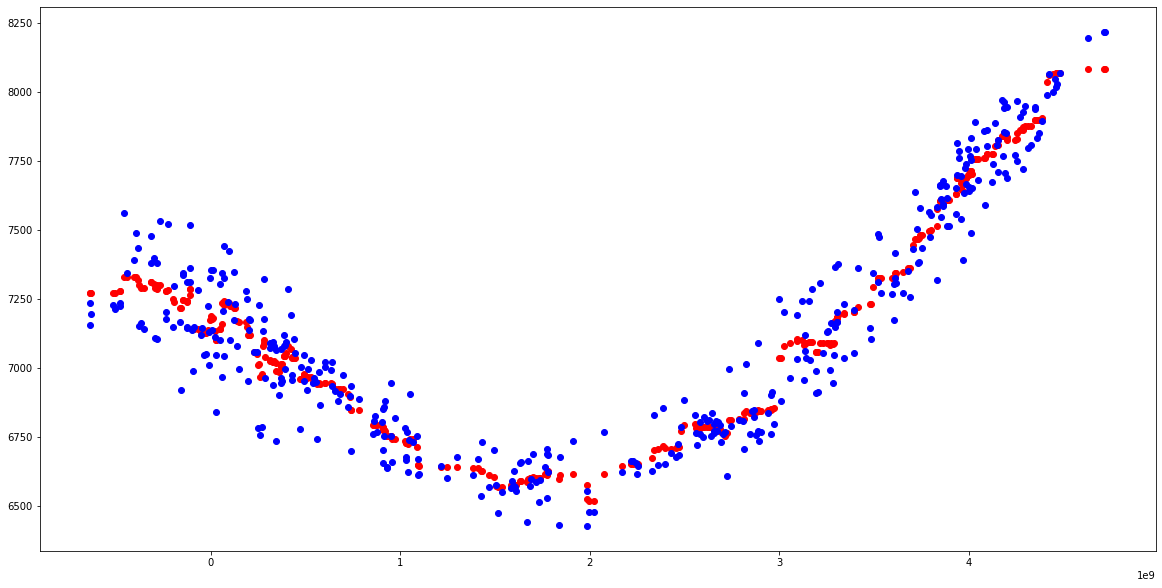

In [23]:
predicted_val = random_rf.predict(x_val.reshape(-1,1))
rf_train = random_rf.predict(x_train.reshape(-1,1))
print('train error : ',mean_absolute_error(rf_train,y_train))
print('validation error : ',mean_absolute_error(predicted_val,y_val))
plt.figure(figsize=(20,10))
train_pred = random_rf.predict(x_train.reshape(-1,1))
plt.scatter(min_max_scaler.inverse_transform(x_train.reshape(-1,1)),train_pred, c = 'r')
plt.scatter(min_max_scaler.inverse_transform(x_train.reshape(-1,1)),y_train, c='b')

plt.show()

Here we allocate the maximum error of trained model as a threshold to detect anomaly

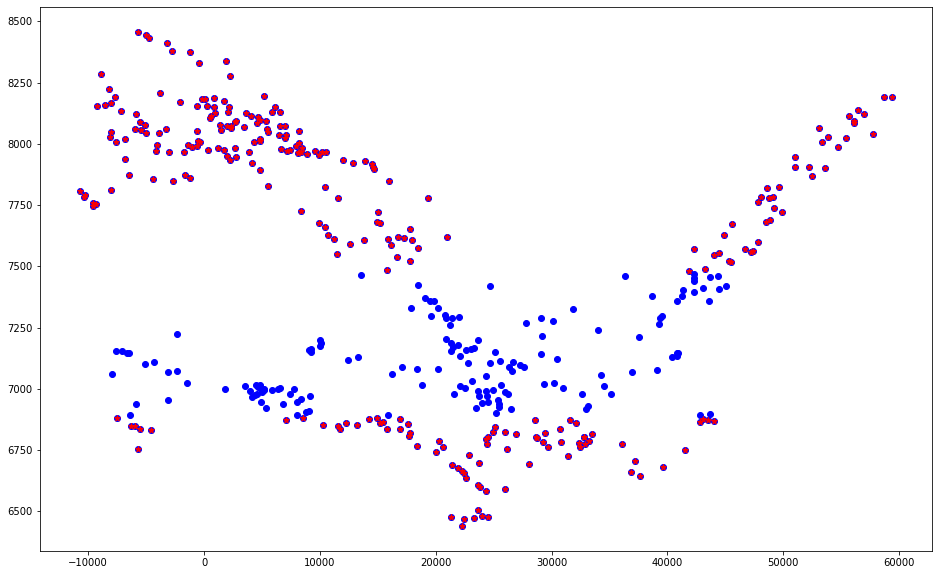

In [24]:

X_test_minmax = min_max_scaler.transform(X_test.reshape(-1,1))
predicted_testset =  random_rf.predict(X_test_minmax.reshape(-1,1))

### threshold of errors
max_err_rf = max(abs(rf_train-y_train))
predicted_val = random_rf.predict(x_val.reshape(-1,1))
rf_threshold = max_err_rf
err = abs(predicted_testset - Y_test)
# Get the anomalous samples
rf_anomalies_idx = (rf_threshold < err).astype(int) #binary map of anomalies
anomalies1 = Y_test[rf_threshold < err]
anomalies0 = X_test[rf_threshold < err]
# anomalies_rf = np.concatenate((anomalies0.reshape(-1,1),anomalies1.reshape(-1,1)), axis = 1)

## plot test set and predicted
plt.figure(figsize=(16,10))
# plt.scatter(X_test, pred_test,c ='r')
plt.scatter(X_test, Y_test,c ='b')
plt.scatter(anomalies0,anomalies1, color='r', marker='*') #anomalies



**KNN**

Now we fit the second model, KNN, on the clean data

train error:  88.14471325242124
val_error:  87.61159006521716


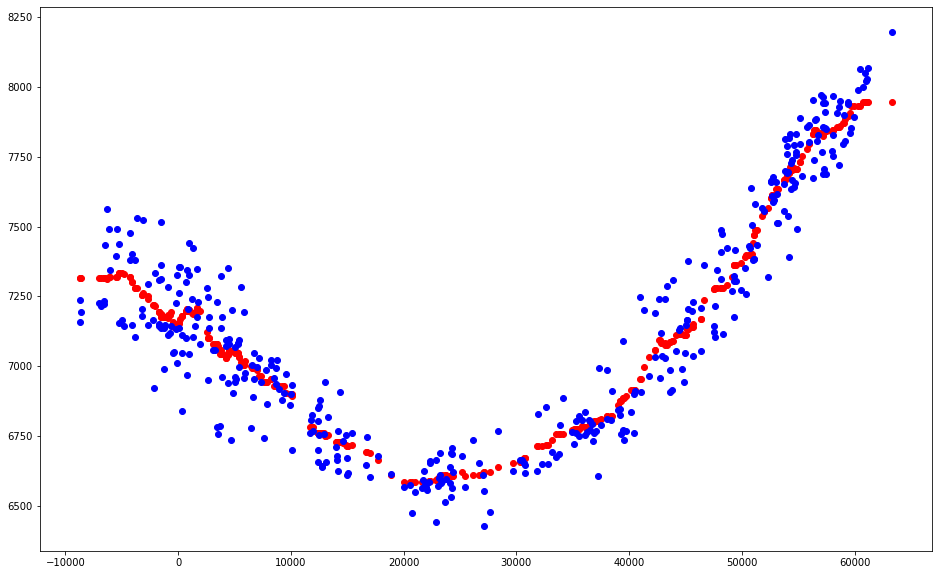

In [40]:
from sklearn.neighbors import KNeighborsRegressor
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train.reshape(-1,1))
x_train, x_val, y_train, y_val = train_test_split(X_train_minmax,Y_train, test_size=0.1)
n = KNeighborsRegressor(n_neighbors=20) # I tried different n_neighbors, 20 was not overfitt
n.fit(x_train.reshape(-1,1), y_train)


pred_val = n.predict(x_val.reshape(-1,1))

## Threshold
pred_train = n.predict(x_train.reshape(-1,1))
max_err_knn = max(abs(y_train-pred_train))
print('train error: ', mean_absolute_error(y_train,pred_train))
print('val_error: ',mean_absolute_error(y_val,pred_val))
# print(max_err_knn)
plt.figure(figsize=(16,10))
plt.scatter(min_max_scaler.inverse_transform(x_train.reshape(-1,1)),pred_train, c = 'r')
plt.scatter(min_max_scaler.inverse_transform(x_train.reshape(-1,1)),y_train, c='b')

In the next step, anomalies of test is detected same as previous model

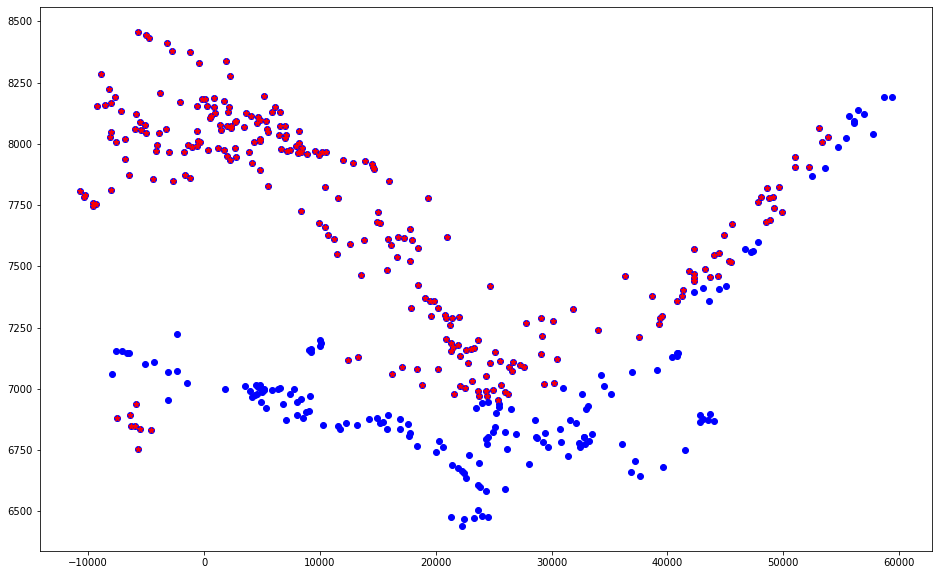

In [41]:
X_test_minmax = min_max_scaler.transform(X_test.reshape(-1,1))
pred_test = n.predict(X_test_minmax.reshape(-1,1))
knn_threshold = max_err_knn
err = abs(pred_test - Y_test)
# Get the anomalous samples
knn_anomalies_idx = (knn_threshold < err).astype(int) # binary map of anomalies
anomalies1 = Y_test[knn_threshold < err]
anomalies0 = X_test[knn_threshold < err]
plt.figure(figsize=(16,10))

# plt.scatter(X_test, pred_test,c ='g')
plt.scatter(X_test, Y_test,c ='b')
plt.scatter(anomalies0,anomalies1, color='r', marker='*')


anomalies_knn = np.concatenate((anomalies0.reshape(-1,1),anomalies1.reshape(-1,1)), axis = 1)

**Gaussian Mixture** <br>

The las approach is based on distribution of data.

In [42]:
from matplotlib.colors import LogNorm
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


In the first step the optimal number of clusters should be found. BIC and AIC are two well-known criterias in this regard.

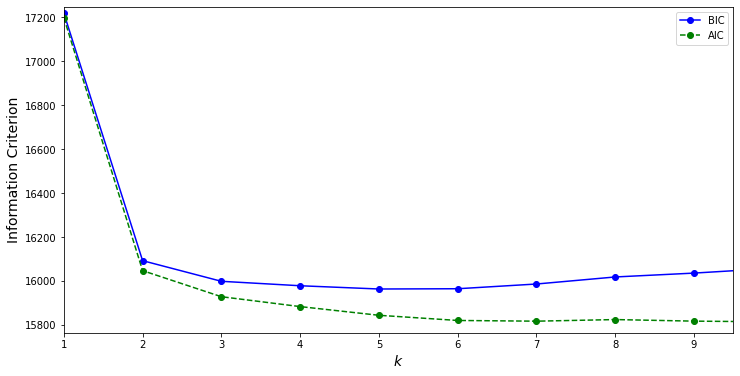

In [43]:
from sklearn.mixture import GaussianMixture
X = new_train[:,1:]  # here we consider whole training set as 2D train set (unsupervised approach)
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=2000).fit(X)
             for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])

plt.legend()

plt.show()

Optimal number of clusters :

In [44]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k,
                              covariance_type=covariance_type
                              ).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type
    
print("\nOptimal k: ", best_k)
print("\nOptimal Covariance Type: ", best_covariance_type)


Optimal k:  5

Optimal Covariance Type:  full


Then we fit the model with 5 cluster as follows:

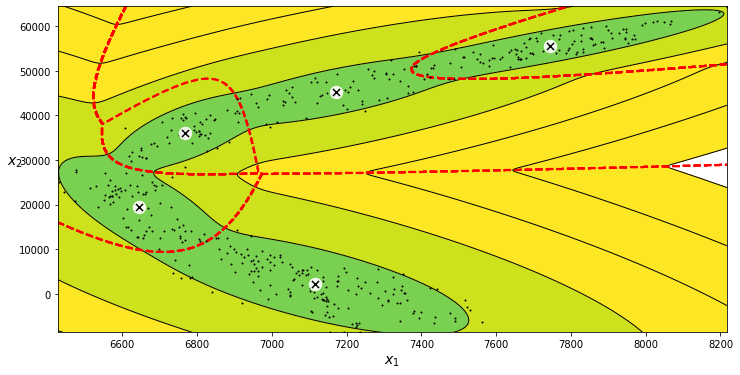

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5,covariance_type='full')
gmm.fit(X)
plt.figure(figsize=(12, 6))

plot_gaussian_mixture(gmm, X)

plt.show()


Now we apply GMM to find anomalies on test set

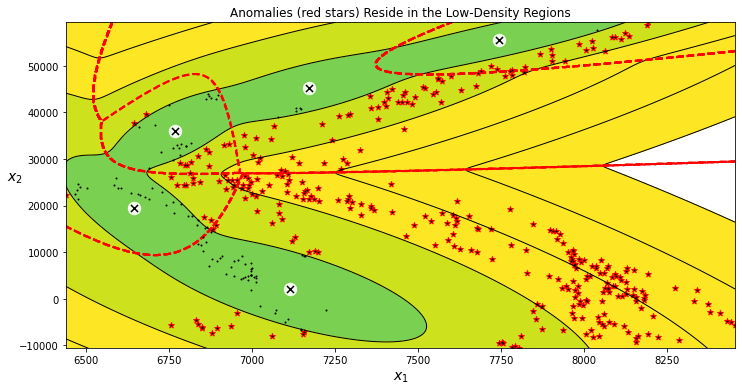

In [45]:
Y = new_test[:,1:]
#Compute the log-likelihood of each sample
densities = gmm.score_samples(Y)
# Define the threshold is at the fourth percentile lowest density
# density_threshold = np.percentile(densities, 4)  #fail

#ToDo : define threshold with train data

density_threshold = np.percentile(gmm.score_samples(X), 5)

# Get the anomalous samples
gmm_anomalies_idx = (densities < density_threshold).astype(int) #binary map of anomalies
anomalies = Y[densities < density_threshold]
density_threshold
plt.figure(figsize=(12, 6))
plt.title("Anomalies (red stars) Reside in the Low-Density Regions")

plot_gaussian_mixture(gmm, Y)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
# plt.ylim(top=5.1)
anomalies_gmm = anomalies
plt.show()

**Last step:** <br>
In the last part three anomalies binary maps are aggregated to find out how many models on which anomalies are agreed.<br> In the first plot with k = 1, at least one model chose each anomaly, say the model is quit strict. With k = 2, at least two models were agreed on anomalies and k = 3 would be the softest one in which just common outliers between three models are chosen

In [46]:
final_anomalies_idx = (knn_anomalies_idx + gmm_anomalies_idx + rf_anomalies_idx)

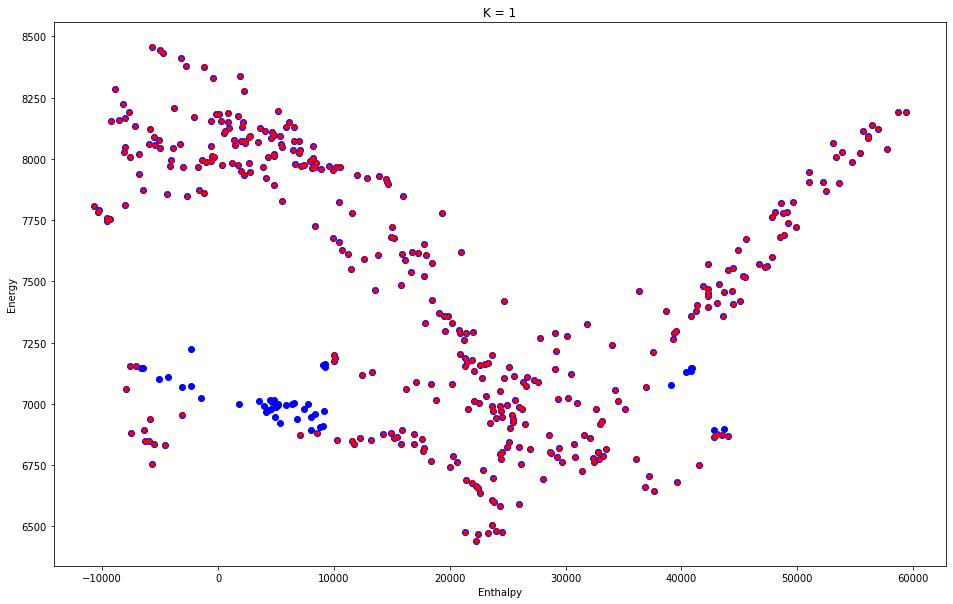

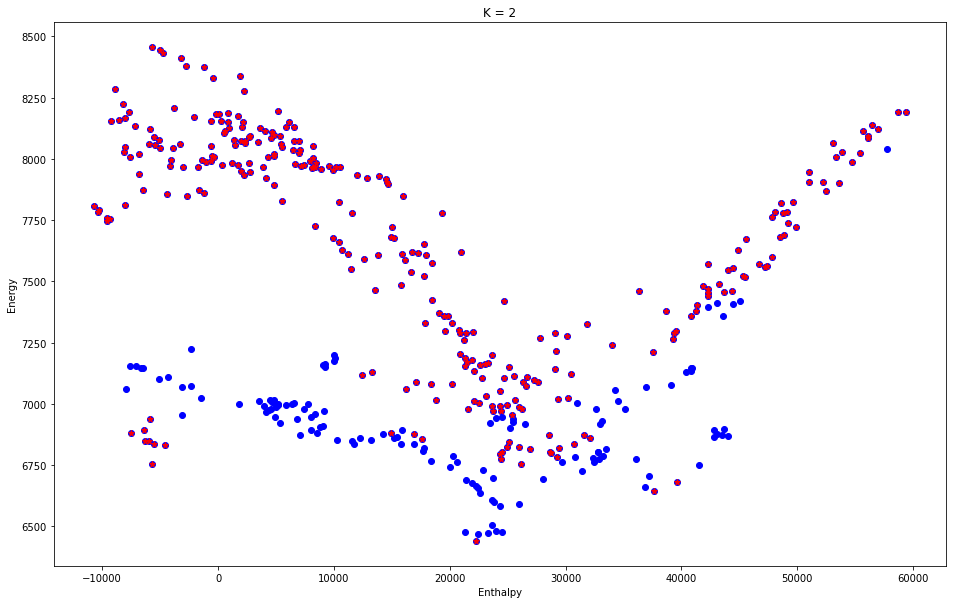

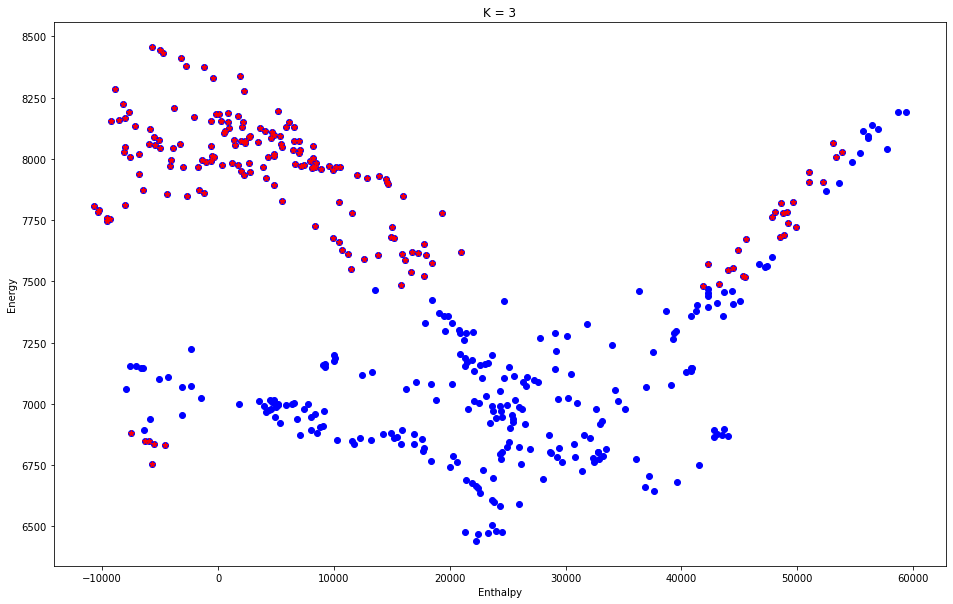

In [47]:
# from importlib import reload
# plt = reload(plt)
for k in range(1, 4):
  plt.figure(figsize=(16,10))
  plt.scatter(X_test, Y_test,c ='b')
  plt.scatter(X_test[final_anomalies_idx >= k], Y_test[final_anomalies_idx >= k], color='r', marker='*')
  plt.xlabel('Enthalpy')
  plt.ylabel('Energy')
  plt.title(f'K = {k}')
  plt.show()


Another visualization

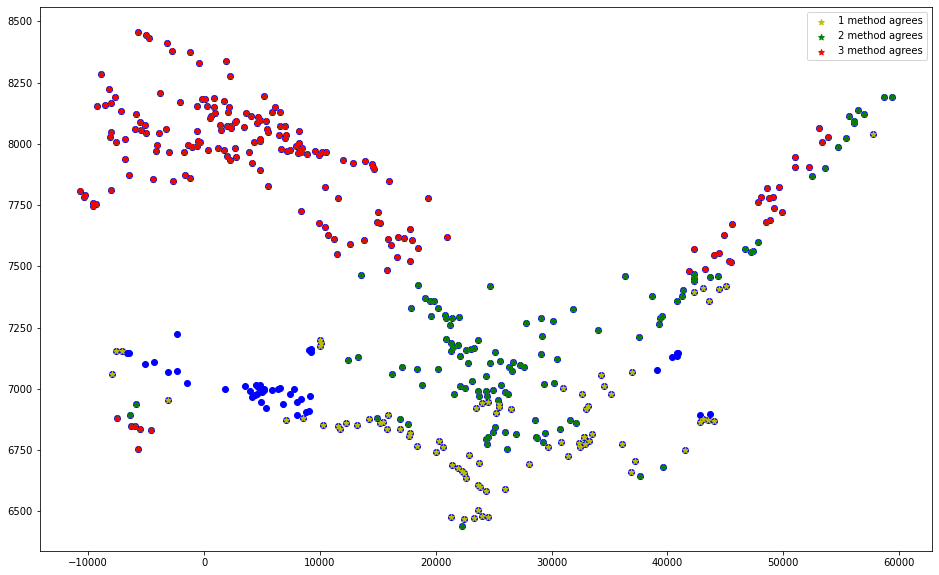

In [48]:
plt.figure(figsize=(16,10))
plt.scatter(X_test, Y_test,c ='b')
colors = ['y', 'g', 'r']
for k in range(1, 4):
  plt.scatter(X_test[final_anomalies_idx >= k],
              Y_test[final_anomalies_idx >= k],
              color=colors[k - 1],
              marker='*',
              label=f"{k} method agrees")

plt.legend(loc="upper right")
plt.show()

Now we can label the anomaly days. I chose k = 3 ,  but the choice of k depends on how hard the model is expected to perform.



In [55]:
labeled_test = test
l = []
for i in range(test.shape[0]):
  if final_anomalies_idx[i] == 3:
    l.append('anomaly')
  else:
    l.append('normal')

labeled_test['label'] = l

In [56]:
labeled_test

,date,energy,enthalpy,label
0,2019-02-22,6938.614286,-5851.336089,normal
1,2019-02-23,7148.391429,-6441.032345,normal
2,2019-02-24,7110.120000,-4349.099258,normal
3,2019-02-25,7072.765714,-2372.592647,normal
4,2019-02-26,7222.465714,-2360.898917,normal
...,...,...,...,...
422,2021-07-22,7904.434286,51036.859400,anomaly
423,2021-07-23,7823.580000,49663.463630,anomaly
424,2021-07-24,7784.828571,49149.005900,anomaly
425,2021-07-25,7779.428571,48810.674380,anomaly
